# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
## Importo las librerías que necesitaré para el proyecto
import gzip
import pandas as pd
import numpy as np
import itertools
import plotly.express as px
import plotly.graph_objects as go
from time import strptime
import gc #Garbage collector
import datetime
import re
import nltk
from nltk.stem import WordNetLemmatizer
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
from IPython.display import display, SVG
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse


In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

# **Reviews**

In [3]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 2 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 2
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [4]:
data_reviews = pd.DataFrame(data_reviews)

In [5]:
## Importo la cabecera del set de datos para averiguar que datos contiene
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
2,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075
3,nd,1.0,2759.0,725280,2,2017-11-28,"endless rooms of some underground complex, blo...",False,1,1.0,NaN,NaN
4,jimllfixitok,1.1,729.0,707610,0,2017-10-16,no sound. icons don't work. re-installed but n...,False,1,NaN,NaN,76561197970402776


In [6]:
data_reviews.shape

(3896535, 12)

In [7]:
## Analizo los valores faltantes de cada una de las columnas
data_reviews.isna().sum()

username              0
hours             13206
products           7531
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     3296831
compensation    3823747
user_id         2308752
dtype: int64

In [8]:
## Solo dejaremos las columnas que creo que pueda ser necesarias preporcesar y utilizar a efectos de agilizar el tratamiento
## de los datos
data_reviews= pd.DataFrame(data_reviews, columns=['username', 'hours','product_id','date','text'])

In [9]:
# Muestro nuevamente el set de datos con las columnas que me parece que voy a poder utilizar
data_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,hello?<,14.6,328100,2017-10-16,Better than Minecraft
2,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...
3,nd,1.0,725280,2017-11-28,"endless rooms of some underground complex, blo..."
4,jimllfixitok,1.1,707610,2017-10-16,no sound. icons don't work. re-installed but n...


In [10]:
### Averiguo que tipo de datos son los que tiene cada columna
data_reviews.dtypes

username       object
hours         float64
product_id     object
date           object
text           object
dtype: object

In [11]:
### Analizando los tipos de datos, me parece importante transformar el tipo de dato "date" a tipo "tiempo" para eso 
### importaremos la librería datetime
import datetime

In [12]:
data_reviews['date'] = pd.to_datetime(data_reviews['date'])

In [13]:
data_reviews.dtypes

username              object
hours                float64
product_id            object
date          datetime64[ns]
text                  object
dtype: object

In [14]:
#Veamos como quedó hasta hora nuestro dataframe
print(data_reviews.shape)
data_reviews.head()

(3896535, 5)


,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,hello?<,14.6,328100,2017-10-16,Better than Minecraft
2,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...
3,nd,1.0,725280,2017-11-28,"endless rooms of some underground complex, blo..."
4,jimllfixitok,1.1,707610,2017-10-16,no sound. icons don't work. re-installed but n...


In [15]:
# Analizamos que porcentaje de datos faltantes quedan en cada columna de reviews
data_reviews.isna().sum()

username          0
hours         13206
product_id        0
date              0
text              0
dtype: int64

In [16]:
# Averiguo como están distribuidos los reviews de los distintos juegos por su id de producto (product_id). 
# De esta manera conozco cuales son los juegos con más información en cuanto a los usuarios que lo jugaron
data_reviews['product_id'].value_counts()

440       91809
252490    51104
49520     36487
377160    35432
271590    29585
          ...  
736140        1
696310        1
752780        1
721420        1
753670        1
Name: product_id, Length: 14970, dtype: int64

In [17]:
# cuantos usuarios hay y cuantas reviews dió cada uno de ellos
data_reviews['username'].value_counts()

123                     1056
Alex                     926
Chris                    742
Nick                     699
Tom                      660
                        ... 
brannen1124                1
Frozerize                  1
It's A Goose!              1
phillipinpc                1
brvzi momo pvpro.com       1
Name: username, Length: 1716724, dtype: int64

In [18]:
#Registros duplicados
data_reviews.drop_duplicates(inplace=True, ignore_index=True)

In [19]:
data_reviews.shape

(3681082, 5)

In [20]:
data_reviews.isna().sum()

username          0
hours         13079
product_id        0
date              0
text              0
dtype: int64

### Tratamiento de Horas Faltantes

Las horas faltantes no son representativas, representan el 0.37 del total de datos del dataframe, por lo tanto, con calcular el promedio de cada usuario sería una buen medida

In [21]:
data_reviews.columns

Index(['username', 'hours', 'product_id', 'date', 'text'], dtype='object')

In [22]:
ordinalCategories = OrdinalEncoder(dtype=int).fit_transform(data_reviews[['username', 'product_id']])
X = np.c_[ordinalCategories, data_reviews.hours]
                                                            
data_imputed = IterativeImputer(random_state=42).fit_transform(X)

In [23]:
# Reemplazado valores imputados en la serie
data_reviews.hours = data_imputed[:,2]

In [24]:
data_reviews.isna().sum()

username      0
hours         0
product_id    0
date          0
text          0
dtype: int64

In [25]:
data_reviews.shape

(3681082, 5)

In [26]:
#Una vez preprocesado el archivo lo guardamos en otro para dejar solo la información que necesitamos
if True:
    data_reviews.to_csv('data_reviews.csv', index= False)

**Preprocesamiento de Games**

In [27]:
# Comencemos a preprocesar el archivo de los juegos. Procedemos a cargarlo de manera que tambien vaya agregando al dataframe
# data_games. En este caso la cantidad de juegos es más pequeña por lo tanto utilizamos la totalidad de los mismos.
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [28]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [29]:
data_games[data_games.id == '35140']
#print(data_games.shape)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [30]:
# En el caso del dataframe de juegos, dejaremos las columnas que nos parece importante. genres, release_date,
# tags, specs, price, id, developer
data_games.drop(columns=['title', 'discount_price', 'reviews_url',
                         'early_access', 'developer', 'sentiment', 'metascore'], inplace=True)
data_games1= pd.DataFrame(data_games, columns=['genres','app_name','release_date','tags','specs','price','id','publisher', 'url'])

In [31]:
print(data_games1.shape)
data_games1.head()

(32135, 9)


,genres,app_name,release_date,tags,specs,price,id,publisher,url
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,761140,Kotoshiro,http://store.steampowered.com/app/761140/Lost_...
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980,"Making Fun, Inc.",http://store.steampowered.com/app/643980/Ironb...
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,670290,Poolians.com,http://store.steampowered.com/app/670290/Real_...
3,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",[Single-player],0.99,767400,彼岸领域,http://store.steampowered.com/app/767400/2222/
4,NaN,Log Challenge,NaN,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,773570,NaN,http://store.steampowered.com/app/773570/Log_C...


De esta manera veo cuales son los datos que contiene cada columna - Publicado por - Genero - fecha de lanzamiento - etiquetas - precio rebajado - Precio - id - desarrollador - sentimiento - metascore

In [32]:
# Que tipo de datos contiene 
data_games1.dtypes

genres          object
app_name        object
release_date    object
tags            object
specs           object
price           object
id              object
publisher       object
url             object
dtype: object

## Transformo 

In [33]:
# Determino la cantidad de datos faltantes (en porcentaje) de cada una de las columnas para determinar cuales puedes ser las 
# que podré darle más peso, y cuales son las que le daré una importancia más relativa teniendo en cuenta esta situación. 
data_games1.isna().sum()

genres          3283
app_name           2
release_date    2067
tags             163
specs            670
price           1377
id                 2
publisher       8052
url                0
dtype: int64

In [34]:
# Video juegos con nombres faltantes
data_games1[data_games1.app_name.isna()]

,genres,app_name,release_date,tags,specs,price,id,publisher,url
74,NaN,NaN,NaN,NaN,NaN,19.99,NaN,NaN,http://store.steampowered.com/
2580,"[Action, Indie]",NaN,2014-08-26,"[Action, Indie]","[Single-player, Game demo]",NaN,317160,NaN,http://store.steampowered.com/app/317160/_/


In [35]:
# me pregunto si habrá videojuegos duplicado, procedo a filtrarlos
data_games1[data_games1.duplicated(
    subset=['id'], keep=False)].sort_values(by='publisher')

,genres,app_name,release_date,tags,specs,price,id,publisher,url
13894,[Action],Wolfenstein II: The New Colossus,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,612880,Bethesda Softworks,http://store.steampowered.com/app/612880/
14573,[Action],Wolfenstein II: The New Colossus,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,612880,Bethesda Softworks,http://store.steampowered.com/app/612880/Wolfe...
30961,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,NaN,"Warner Bros. Interactive Entertainment, Feral ...",http://store.steampowered.com/app/200260
74,NaN,NaN,NaN,NaN,NaN,19.99,NaN,NaN,http://store.steampowered.com/


y los elimino

In [36]:
data_games1.drop_duplicates(subset=['id'], ignore_index=True, inplace=True)

In [37]:
data_games1[data_games1.duplicated(
    subset=['id'], keep=False)].sort_values(by='publisher')

,genres,app_name,release_date,tags,specs,price,id,publisher,url


In [38]:
data_games1[data_games1.id.isna()]

,genres,app_name,release_date,tags,specs,price,id,publisher,url
74,NaN,NaN,NaN,NaN,NaN,19.99,NaN,NaN,http://store.steampowered.com/


In [39]:
# Cuantas valores faltantes data_games.isna().sum()
data_games1.isna().sum()

genres          3283
app_name           2
release_date    2067
tags             163
specs            670
price           1377
id                 1
publisher       8052
url                0
dtype: int64

Necesito conocer cual es el juego más popular, para medir esto necesito determinar cuantos usuarios lo juegan y cuantas horas lo han jugado cada uno.

In [40]:
isNan_genre_tag = data_games1.genres.isna() & data_games.specs.isna()
data_games1 = data_games1[~isNan_genre_tag]
print(data_games1.shape)

(31862, 9)


<ipython-input-40-e5b5ab29bcdb>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_games1 = data_games1[~isNan_genre_tag]


In [41]:
data_games1.isna().sum()

genres          3012
app_name           1
release_date    2040
tags             155
specs            437
price           1373
id                 0
publisher       7783
url                0
dtype: int64

### Filtrado de categoría

In [42]:
# Filtraremos las categorías que tienen valores nulos en genres y specs
isNan_genre_tag = data_games1.genres.isna() & data_games1.specs.isna()
data_games1 = data_games1[~isNan_genre_tag]
print(data_games1.shape)

(31711, 9)


In [43]:
data_games1.isna().sum()

genres          2861
app_name           1
release_date    2040
tags             152
specs            286
price           1369
id                 0
publisher       7632
url                0
dtype: int64

In [44]:
#Pienso en rellenar con una lista vacía los valores faltantes en 'genres','tags','specs' que son los que me servirá para
#conocer la similitud de los juegos
for col in ['genres', 'tags', 'specs']:
    data_games1[col].fillna({i: [] for i in data_games1.index}, inplace=True)

In [45]:
data_games1.isna().sum()

genres             0
app_name           1
release_date    2040
tags               0
specs              0
price           1369
id                 0
publisher       7632
url                0
dtype: int64

In [46]:
#Para trabajar con los arrays que encuentro en las columnas genres, tags y specs debo importar numpy

import numpy as np

#Todas las categorías
data_games1['categories'] = data_games1['genres'] + data_games1['tags'] + data_games1['specs']


In [47]:
data_games1.head(2)

,genres,app_name,release_date,tags,specs,price,id,publisher,url,categories
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,761140,Kotoshiro,http://store.steampowered.com/app/761140/Lost_...,"[Action, Casual, Indie, Simulation, Strategy, ..."
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980,"Making Fun, Inc.",http://store.steampowered.com/app/643980/Ironb...,"[Free to Play, Indie, RPG, Strategy, Free to P..."


In [48]:
import itertools

#Obtencion de categorías únicas
data_games1['categories'] = [np.unique(cat) for cat in data_games1.categories]


#Obtencion de categorías únicas
np.unique(list(itertools.chain(*data_games1.categories)))

array(['1980s', "1990's", '2.5D', '2D', '2D Fighter', '360 Video',
       '3D Platformer', '3D Vision', '4 Player Local', '4X', '6DOF',
       'Abstract', 'Accounting', 'Action', 'Action RPG',
       'Action-Adventure', 'Adventure', 'Agriculture', 'Aliens',
       'Alternate History', 'America', 'Animation & Modeling',
       'Animation &amp; Modeling', 'Anime', 'Arcade', 'Arena Shooter',
       'Artificial Intelligence', 'Assassin', 'Asynchronous Multiplayer',
       'Atmospheric', 'Audio Production', 'Base Building',
       'Based On A Novel', 'Basketball', 'Batman', "Beat 'em up",
       'Benchmark', 'Bikes', 'Blood', 'Board Game', 'Bowling', 'Building',
       'Bullet Hell', 'Bullet Time', 'CRPG', 'Capitalism',
       'Captions available', 'Card Game', 'Cartoon', 'Cartoony', 'Casual',
       'Character Action Game', 'Character Customization', 'Chess',
       'Choices Matter', 'Choose Your Own Adventure', 'Cinematic',
       'City Builder', 'Class-Based', 'Classic', 'Clicker', 'Co-o

In [49]:
#Removiendo caracteres, ej: Single-player singleplayer, Multiplayer, MultiPlayer, Multi-Player
data_games1['categories'] = [[re.sub(r'[^\w\s]', '', subcat).lower() for subcat in cat] 
                            for cat in data_games1.categories]

In [50]:
data_games1['categories']

0        [action, casual, indie, simulation, singleplay...
1        [2d, board game, card game, character customiz...
2        [casual, free to play, inapp purchases, indie,...
3                [action, adventure, casual, singleplayer]
4        [action, casual, full controller support, htc ...
                               ...                        
32128    [casual, indie, simulation, singleplayer, stea...
32129    [casual, indie, singleplayer, stats, steam ach...
32130    [indie, racing, simulation, singleplayer, stea...
32131    [atmospheric, casual, indie, puzzle, relaxing,...
32132    [action, adventure, early access, htc vive, in...
Name: categories, Length: 31711, dtype: object

In [51]:
#Haciendo una revisión de todos las categorías de manera manual, elimino las que no considero "games"
INVALID_CATEGORIES = ['photo editing', 'game development', 'documentary', 'video production', 'tutorial', 'software',
                      'movie', 'software training', 'soundtrack', 'utilities', 'accounting', 'downloadable content']

In [52]:
def getTuplesPandas(search_list):
    return pd.DataFrame([game for game in data_games1.itertuples()
            if np.isin(search_list, game.categories).sum() > 0])

In [53]:

data_games1 = data_games1[~data_games.id.isin(getTuplesPandas(INVALID_CATEGORIES).id)]


<ipython-input-53-5c110f7cc1d2>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_games1 = data_games1[~data_games.id.isin(getTuplesPandas(INVALID_CATEGORIES).id)]


In [54]:
data_games1.shape

(18037, 10)

* Nos quedó un dataframe de 18037 juegos y 10 columnas; Dado que Spec y tags los resumimos en categories, las vamos a eliminar

In [55]:
data_games1.drop(['specs', 'tags'], inplace=True, axis=1)

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [57]:
data_games1.head()

,genres,app_name,release_date,price,id,publisher,url,categories
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.99,761140,Kotoshiro,http://store.steampowered.com/app/761140/Lost_...,"[action, casual, indie, simulation, singleplay..."
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,Free To Play,643980,"Making Fun, Inc.",http://store.steampowered.com/app/643980/Ironb...,"[2d, board game, card game, character customiz..."
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,Free to Play,670290,Poolians.com,http://store.steampowered.com/app/670290/Real_...,"[casual, free to play, inapp purchases, indie,..."
3,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,0.99,767400,彼岸领域,http://store.steampowered.com/app/767400/2222/,"[action, adventure, casual, singleplayer]"
4,[],Log Challenge,NaN,2.99,773570,NaN,http://store.steampowered.com/app/773570/Log_C...,"[action, casual, full controller support, htc ..."


In [58]:
data_games1['genres'] = data_games1['genres'].apply(lambda x: np.nan if len(x) == 0 else x)

In [59]:
data_games1.isna().sum()

genres          1838
app_name           1
release_date    1614
price            883
id                 0
publisher       2909
url                0
categories         0
dtype: int64

#### Transformando precios

In [60]:
#La columna price está conformada por valores numéricos y categóricos
category_prices = lambda x: np.unique(np.array([i for i in list(x) if type(i) == str]))

In [61]:
category_prices(data_games1.price)

array(['Free', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod',
       'Free Movie', 'Free To Play', 'Free to Play', 'Play Now',
       'Play WARMACHINE: Tactics Demo', 'Play for Free!', 'Third-party'],
      dtype='<U29')

In [62]:
def transform_prices(df):
    df['category_price'] = df.price.apply(
        lambda p: 'paid' if (type(p) == float or p.startswith('Starting')) else 'free')
    df.drop('price', axis=1, inplace=True)

In [63]:
transform_prices(data_games1)
data_games1.head()

,genres,app_name,release_date,id,publisher,url,categories,category_price
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,761140,Kotoshiro,http://store.steampowered.com/app/761140/Lost_...,"[action, casual, indie, simulation, singleplay...",paid
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,643980,"Making Fun, Inc.",http://store.steampowered.com/app/643980/Ironb...,"[2d, board game, card game, character customiz...",free
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,670290,Poolians.com,http://store.steampowered.com/app/670290/Real_...,"[casual, free to play, inapp purchases, indie,...",free
3,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,767400,彼岸领域,http://store.steampowered.com/app/767400/2222/,"[action, adventure, casual, singleplayer]",paid
4,NaN,Log Challenge,NaN,773570,NaN,http://store.steampowered.com/app/773570/Log_C...,"[action, casual, full controller support, htc ...",paid


In [64]:
data_games1.isnull().sum()

genres            1838
app_name             1
release_date      1614
id                   0
publisher         2909
url                  0
categories           0
category_price       0
dtype: int64

In [65]:
#Una vez preprocesado el archivo lo guardamos en otro para dejar solo la información que necesitamos
if True:
    data_games1.to_csv('data_games.csv', index= False)

## Consultas

A partir de ahora trabajaremos con los archivos procesados 'data_reviews.csv' y 'data_games.csv' - 
En el archivo data_reviews.csv pandas transforma los usuarios null en NaN, por lo tanto debemos transformar esta a string
En el caso de data_games.csv puede ser que se hayan perdido el formato de algunos datos como los de la columna categories, por ejemplo.

In [66]:
#Importamos el nuevo archivo generado
import pandas as pd
data_reviews = pd.read_csv(f'data_reviews.csv', converters={'username': str, 'text': str, 'genres':str, 'categories':str})
data_reviews.date = pd.to_datetime(data_reviews.date)

In [67]:
def toList(x):
    return x[1:-1].replace("'", '').split(', ') if (x is not np.nan) else nan

In [68]:
data_games = pd.read_csv(f'data_games.csv',
                         converters={
                             'genres': lambda x: toList(x),
                             'tags': lambda x: toList(x),
                             'specs': lambda x: toList(x),
                             'categories': str
                         })
#data_games.release_date = pd.to_datetime(data_games.release_date)

In [69]:
print('Reviews:\n', data_reviews.dtypes, '\n')
print('Games\n', data_games.dtypes)

Reviews:
 username              object
hours                float64
product_id             int64
date          datetime64[ns]
text                  object
dtype: object 

Games
 genres            object
app_name          object
release_date      object
id                 int64
publisher         object
url               object
categories        object
category_price    object
dtype: object


In [70]:
data_games1.head(3)

,genres,app_name,release_date,id,publisher,url,categories,category_price
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,761140,Kotoshiro,http://store.steampowered.com/app/761140/Lost_...,"[action, casual, indie, simulation, singleplay...",paid
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,643980,"Making Fun, Inc.",http://store.steampowered.com/app/643980/Ironb...,"[2d, board game, card game, character customiz...",free
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,670290,Poolians.com,http://store.steampowered.com/app/670290/Real_...,"[casual, free to play, inapp purchases, indie,...",free


In [71]:
data_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,hello?<,14.6,328100,2017-10-16,Better than Minecraft
2,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...
3,nd,1.0,725280,2017-11-28,"endless rooms of some underground complex, blo..."
4,jimllfixitok,1.1,707610,2017-10-16,no sound. icons don't work. re-installed but n...




##### Es importante hacernos las preguntas que nos ayuden a entender el negocio y las evaluaciones que podemos hacer 


Preguntas que surgen ;

*Cuales son los juegos más populares en función de la cantidad de usuarios registrados en los mismos 

*Cuales son los juegos que más horas se jugaron de acuerdo a la información 

*Cuales son los juegos menos populares en función de la cantidad de usuarios registrados en los mismos

*Necesito armar una lista con los generos que utiliza cada juego para poder determinar la similaridad item-item

*Que precio poner en función a las recomendaciones de los juegos que han pagado

*La idea para el sistema recomendador es, de acuerdo al género, cantidad de horas jugadas y usuario, esto nos dar'a la similaridad para realizar las recomendaciones necesarias 


In [72]:
cantidad_por_productoId = data_reviews.groupby('product_id').product_id.count().reset_index(name='amount')

## Usuarios únicos

In [73]:
print(f'{len(data_reviews.username.value_counts())} usuarios únicos')

1716724 usuarios únicos


## Top 10 juegos más populares

In [74]:
cantidad_por_productoId = data_reviews.groupby('product_id').product_id.count().reset_index(name='amount')

Merge entre videojuegos y reviews:

In [75]:
reviews_games_amount = pd.merge(cantidad_por_productoId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='amount', ascending=False)
top10 = reviews_games_amount.head(10)

In [76]:
top10.head()

,product_id,amount,genres,app_name,release_date,id,publisher,url,categories,category_price
19,440,76875,"[Action, Free to Play]",Team Fortress 2,2007-10-10,440,Valve,http://store.steampowered.com/app/440/Team_For...,"['action', 'captions available', 'cartoon', 'c...",free
1817,252490,43318,"[Action, Adventure, Indie, Massively Multiplay...",Rust,2013-12-11,252490,Facepunch Studios,http://store.steampowered.com/app/252490/Rust/,"['action', 'adventure', 'building', 'coop', 'c...",paid
2170,271590,25273,"[Action, Adventure]",Grand Theft Auto V,2015-04-14,271590,Rockstar Games,http://store.steampowered.com/app/271590/Grand...,"['action', 'adventure', 'atmospheric', 'coop',...",paid
2777,301520,24896,"[Action, Free to Play, Indie, Massively Multip...",Robocraft,2017-08-24,301520,Freejam,http://store.steampowered.com/app/301520/Roboc...,"['action', 'adventure', 'building', 'crafting'...",free
1417,221100,24222,"[Action, Indie, Massively Multiplayer, Early A...",DayZ,2013-12-16,221100,Bohemia Interactive,http://store.steampowered.com/app/221100/DayZ/,"['action', 'adventure', 'atmospheric', 'coop',...",paid


In [77]:
# Valores para mostrar en la leyenda de cada barra
HOVER_DATA_COLUMNS = ['publisher', 'release_date', 'genres', 'category_price']


In [78]:
pip install kaleido

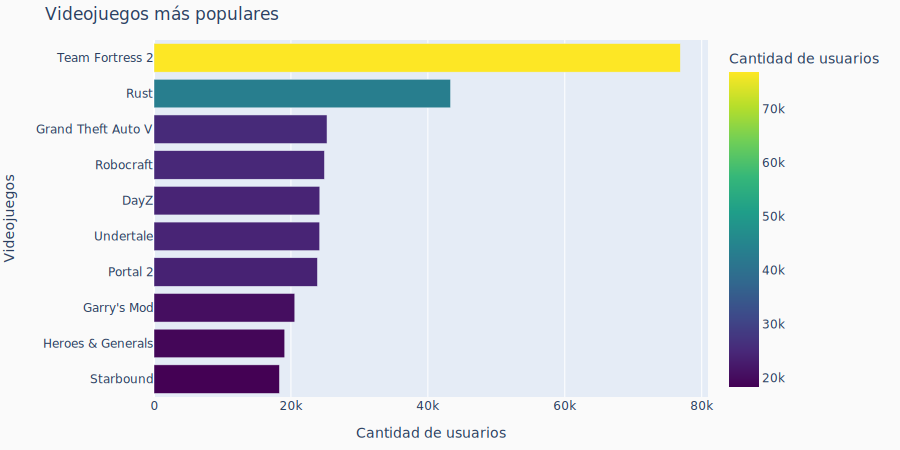

In [79]:

fig = px.bar(top10.sort_values(by='amount'), y='app_name', x='amount', color='amount', title='Videojuegos más populares',
             color_continuous_scale='viridis',
             labels={'app_name': 'Videojuegos',
                     "amount": 'Cantidad de usuarios'},
             hover_data=HOVER_DATA_COLUMNS,
             width=900,
             height=450
             )
fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=40, b=50)
                  )
# Jupyter
#fig.show()

# Static
display(SVG(fig.to_image(format='svg')))

In [80]:
# Valores para mostrar en la leyenda de cada barra
HOVER_DATA_COLUMNS = ['publisher', 'release_date', 'genres', 'category_price']

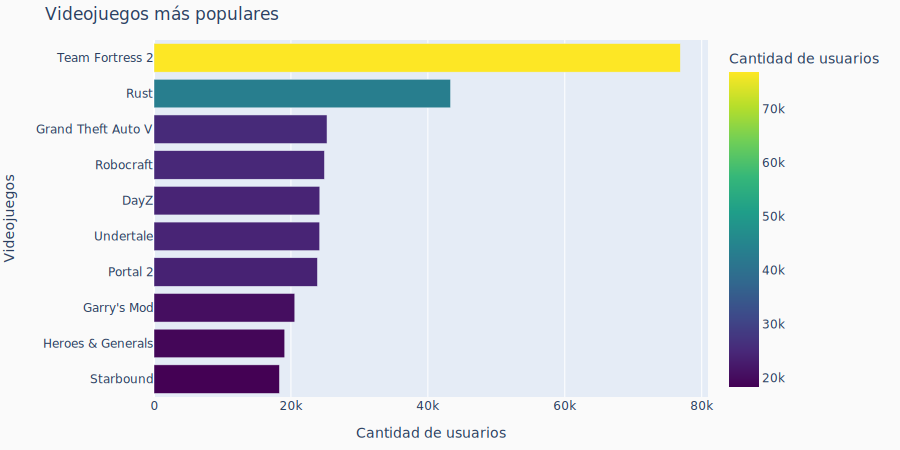

In [81]:
fig = px.bar(top10.sort_values(by='amount'), y='app_name', x='amount', color='amount', title='Videojuegos más populares',
             color_continuous_scale='viridis',
             labels={'app_name': 'Videojuegos',
                     "amount": 'Cantidad de usuarios'},
             hover_data=HOVER_DATA_COLUMNS,
             width=900,
             height=450
             )
fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=40, b=50)
                  )
# Jupyter
#fig.show()

# Static
display(SVG(fig.to_image(format='svg')))

Videos con más tiempo de juego

In [82]:
hours_by_productId = data_reviews.groupby('product_id', as_index=False).hours.sum()

reviews_games_hours = pd.merge(hours_by_productId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='hours', ascending=False)

hours10 = reviews_games_hours.head(10).sort_values(by='hours')

C:\Users\sbertaina\Miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='product_id', ylabel='Density'>

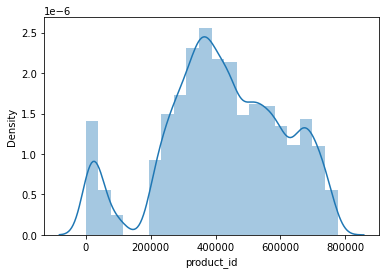

In [83]:
sns.distplot(hours_by_productId['product_id'], bins = 20)

### Género más popular

In [84]:
all_genres = list(itertools.chain(*data_games.genres))
value, count = np.unique(all_genres, return_counts=True)
order = np.argsort(count)

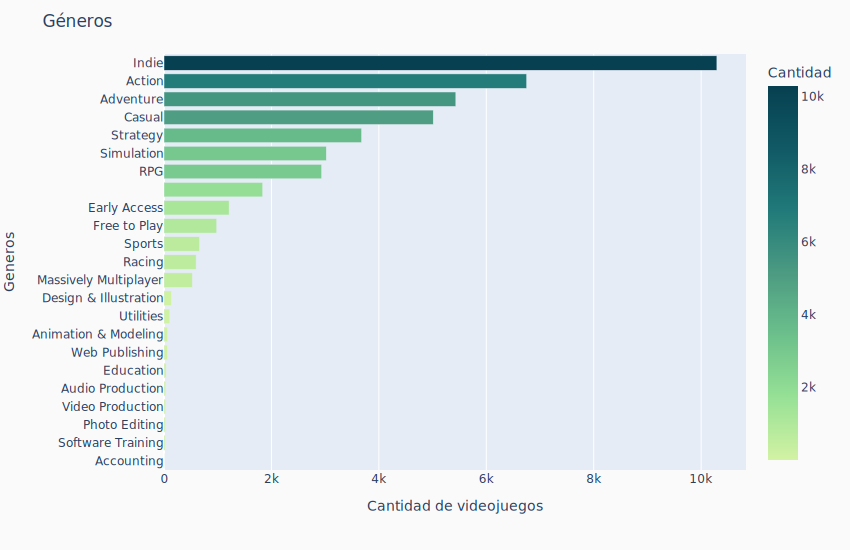

In [85]:
fig = px.bar(x=count[order], y=value[order], color=count[order],
             color_continuous_scale='emrld',
             title='Géneros',
             labels={
                 'x': 'Cantidad de videojuegos',
                 'y': 'Generos', 'color': 'Cantidad'},
             width=850,
             height=550,
             # log_x=True,
             )
fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=10, r=20, t=54)
                  )
#fig.show()
display(SVG(fig.to_image(format='svg')))

### Juegos de pago más jugados

In [86]:
df_items = data_games.query('category_price=="paid"')
merge_paid_games = pd.merge(cantidad_por_productoId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

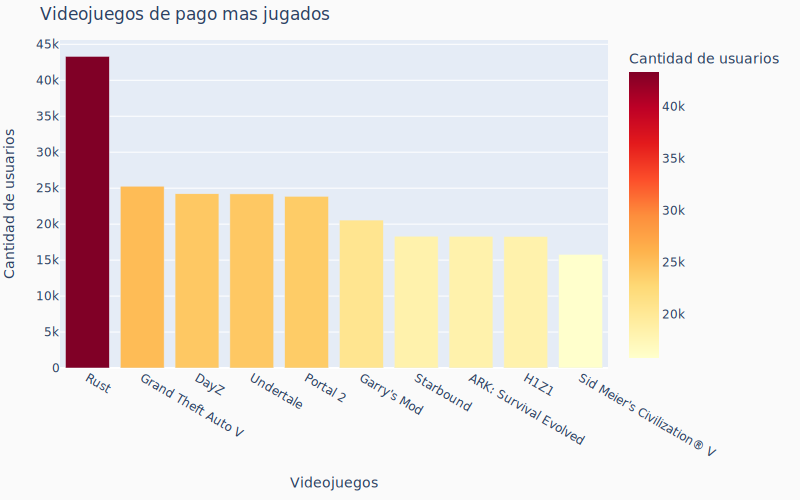

In [87]:
fig = px.bar(data_frame=merge_paid_games, x='app_name', y='amount', title='Videojuegos de pago mas jugados',
             labels={'app_name': 'Videojuegos',
                     'amount': 'Cantidad de usuarios'},
             hover_data=HOVER_DATA_COLUMNS,
             color=merge_paid_games.amount, color_continuous_scale='ylorrd',
             width=800,
             height=500
             )

fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=30, r=20, t=40, b=30)
                  )
#fig.show()
display(SVG(fig.to_image(format='svg')))

### Juegos gratis más jugados

In [88]:
df_items = data_games.query('category_price=="free"')
merge_free_games = pd.merge(cantidad_por_productoId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

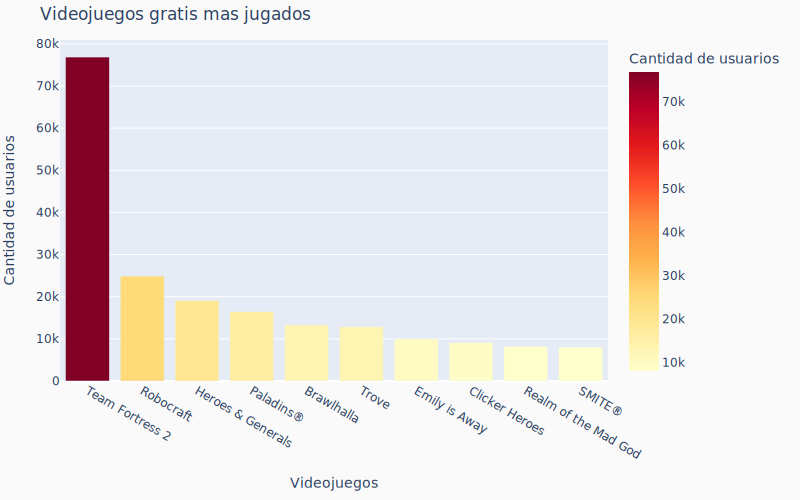

In [89]:
fig = px.bar(data_frame=merge_free_games, x='app_name', y='amount', title='Videojuegos gratis mas jugados',
             labels={'app_name': 'Videojuegos',
                     'amount': 'Cantidad de usuarios', 'color': 'Cantidad'},
             hover_data=HOVER_DATA_COLUMNS,
             color=merge_free_games.amount, color_continuous_scale='ylorrd',
             width=800,
             height=500)

fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(l=20, r=20, t=40, b=30)
                  )
#fig.show()
display(SVG(fig.to_image(format='svg')))

### Porcentaje de usuarios por precio de video juegos

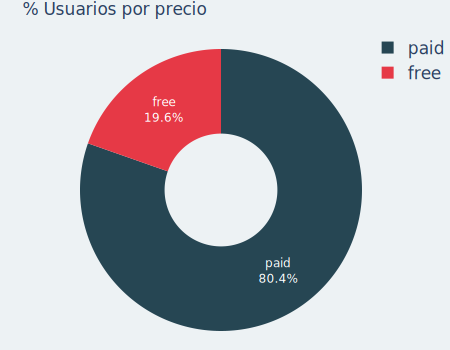

In [90]:
fig = px.pie(reviews_games_amount,
             names='category_price',
             values='amount',
             title='% Usuarios por precio',
             width=450,
             height=350,
             hole=0.4,
             color_discrete_sequence=('#264653', '#E63946'),
             labels={'category_price': 'Tipo Precio', 'amount': 'Cantidad'}
             )

fig.update_layout(
    margin=dict(t=30, b=0),
    legend=dict(font=dict(size=17)),
    paper_bgcolor='#edf2f4'
)
fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show()
display(SVG(fig.to_image(format='svg')))

###  Sistemas de Recomendación

#### Nuevos Usuarios

A los nuevos usuarios se les recomendará automáticamente los videojuegos más populares, al consumirlos serán tenidos en cuenta por el algoritmo recomendador para futuras recomendaciones:

In [91]:
def plot_table(df):
    COLUMNS_FOR_USER = ['app_name', 'url', 'category_price']
    fig = go.Figure(go.Table(
        header=dict(values=['Videojuego', 'Sitio web', 'Tipo de precio'],
                    fill_color='#ffd166',
                    font=dict(size=13)),
        cells=dict(values=np.vstack(df[COLUMNS_FOR_USER].values).T,
                   fill_color='#264653',
                   line_color='black',
                   line_width=.4,
                   font=dict(color='#f1faee'),
                   height=30),
        columnwidth=[1.5, 4, 1]))

    fig.update_layout(width=1000, height=370, margin=dict(t=10, b=0, l=0))
    return display(SVG(fig.to_image('svg')))

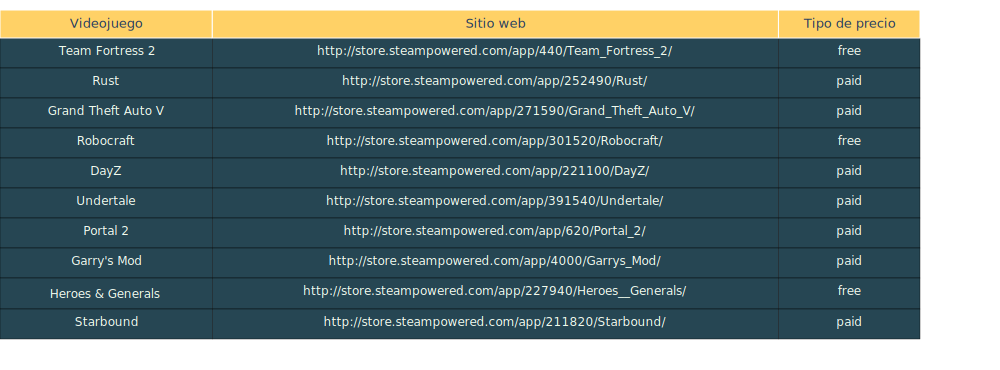

In [92]:
plot_table(reviews_games_amount.head(10))

## Benchmark

Como Benchmark, me parece importante poder recomendar juegos en base a cuales fueron los más jugados es decir los más 
populares, sin tener en cuenta, ni item-item, ni usuario-usuario, ni usuario-item

In [93]:
def get_popularity_recommendations(username, top=10):
    df_recs = reviews_games_amount[~reviews_games_amount.id.isin(
        data_reviews.query('username==@username').product_id)]
    plot_table(df_recs.head(top))

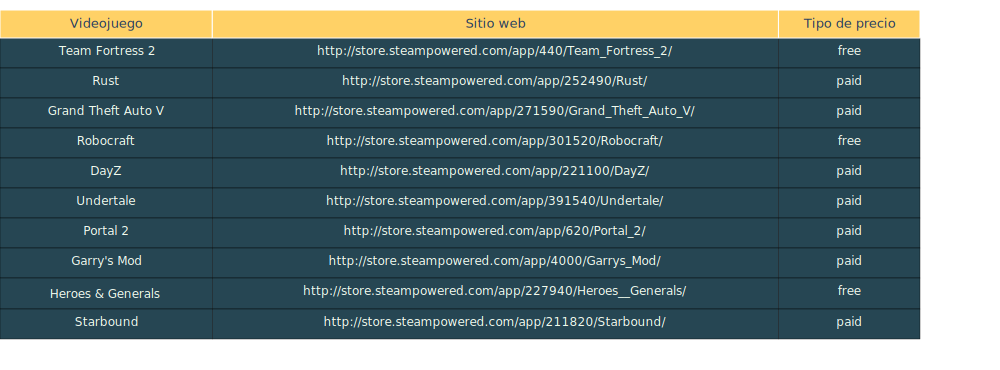

In [94]:
get_popularity_recommendations('nd')

## Filtro colaborativo
La implementación de un filtro colaboratorio conlleva muchos retos, algunos de ellos se han estado solucionando en pasos anteriores con la limpieza y procesamiento de los datos, sin embargo, para el desarrollo de éste proyecto se realizó una etapa de investigación adicional para solucionar la ausencia de calificaciones entre los pares usuario-item el cual era un campo esperado cuando se importaron los datos.
Desde luego, en el consumo de contenidos digitales los usuarios no suelen brindar una calificación explícita que cuantifique su gusto o apreciación hacia cierto producto, un hecho que nos lleva a mirar este desafio como un problema que se volvería a repetir en un caso real.



In [95]:
data_games.head()

,genres,app_name,release_date,id,publisher,url,categories,category_price
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,761140,Kotoshiro,http://store.steampowered.com/app/761140/Lost_...,"['action', 'casual', 'indie', 'simulation', 's...",paid
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,643980,"Making Fun, Inc.",http://store.steampowered.com/app/643980/Ironb...,"['2d', 'board game', 'card game', 'character c...",free
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,670290,Poolians.com,http://store.steampowered.com/app/670290/Real_...,"['casual', 'free to play', 'inapp purchases', ...",free
3,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,767400,彼岸领域,http://store.steampowered.com/app/767400/2222/,"['action', 'adventure', 'casual', 'singleplayer']",paid
4,[],Log Challenge,NaN,773570,NaN,http://store.steampowered.com/app/773570/Log_C...,"['action', 'casual', 'full controller support'...",paid


In [96]:
data_games.dtypes


genres            object
app_name          object
release_date      object
id                 int64
publisher         object
url               object
categories        object
category_price    object
dtype: object

In [97]:
data_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,hello?<,14.6,328100,2017-10-16,Better than Minecraft
2,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...
3,nd,1.0,725280,2017-11-28,"endless rooms of some underground complex, blo..."
4,jimllfixitok,1.1,707610,2017-10-16,no sound. icons don't work. re-installed but n...


In [98]:
data_reviews.dtypes

username              object
hours                float64
product_id             int64
date          datetime64[ns]
text                  object
dtype: object

In [99]:
data_games['id'] = data_games['id'].astype(pd.Int64Dtype())


In [100]:
#Ordeno las columnas de data_games y data_reviews por 'id' que es la llave que utilizaré para hacer merge
data_reviews = data_reviews.sort_values('product_id')
data_games = data_games.sort_values('id')

In [101]:
reviews_games = pd.merge(data_reviews, data_games[['app_name','id', 'category_price', 'categories']],
                        left_on='product_id',
                        right_on='id',
                        how='left')


In [102]:
reviews_games.head()
reviews_games['id'] = reviews_games['id'].astype(pd.Int64Dtype())

In [103]:
reviews_games.head()

,username,hours,product_id,date,text,app_name,id,category_price,categories
0,twitch.tv/miljoo,110.2,10,2017-12-26,i suck at this game,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas..."
1,[NC] Cake,1.6,10,2017-12-29,Good,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas..."
2,Matuzka,1.6,10,2017-12-29,Good old times!,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas..."
3,smselby27,19.1,10,2017-12-29,i love this game so much i love it too much,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas..."
4,japa,1360.7,10,2017-12-29,best game ever !,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas..."


In [104]:
reviews_games.dtypes

username                  object
hours                    float64
product_id                 int64
date              datetime64[ns]
text                      object
app_name                  object
id                         Int64
category_price            object
categories                object
dtype: object

In [105]:
reviews_games.isna().sum()

username               0
hours                  0
product_id             0
date                   0
text                   0
app_name          879178
id                879178
category_price    879178
categories        879178
dtype: int64

In [106]:
reviews_games.shape

(3681082, 9)

In [107]:
reviews_games = reviews_games.dropna(axis=0, subset=['id'])

In [108]:
reviews_games.isna().sum()

username          0
hours             0
product_id        0
date              0
text              0
app_name          0
id                0
category_price    0
categories        0
dtype: int64

In [109]:
import string


In [110]:
reviews_games['n_categories'] = reviews_games['categories'].str.replace('[{}]'.format(string.punctuation),' ')

In [111]:
reviews_games.head()

,username,hours,product_id,date,text,app_name,id,category_price,categories,n_categories
0,twitch.tv/miljoo,110.2,10,2017-12-26,i suck at this game,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...
1,[NC] Cake,1.6,10,2017-12-29,Good,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...
2,Matuzka,1.6,10,2017-12-29,Good old times!,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...
3,smselby27,19.1,10,2017-12-29,i love this game so much i love it too much,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...
4,japa,1360.7,10,2017-12-29,best game ever !,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...


In [112]:
cant_filas = len(reviews_games['categories'])
print(cant_filas)
#reviews_games['categories'][1]

2801904


In [113]:
reviews_games.head()

,username,hours,product_id,date,text,app_name,id,category_price,categories,n_categories
0,twitch.tv/miljoo,110.2,10,2017-12-26,i suck at this game,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...
1,[NC] Cake,1.6,10,2017-12-29,Good,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...
2,Matuzka,1.6,10,2017-12-29,Good old times!,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...
3,smselby27,19.1,10,2017-12-29,i love this game so much i love it too much,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...
4,japa,1360.7,10,2017-12-29,best game ever !,Counter-Strike,10,paid,"['1980s', '1990s', 'action', 'assassin', 'clas...",1980s 1990s action assassin clas...


Para trabajar con indice de Jaccard o Similitud coseno, podría comparar las similaridades entre las categorias de los juegos que juega cada usuario

In [114]:
 print(reviews_games['n_categories'][0])

  1980s    1990s    action    assassin    classic    competitive    fps    firstperson    military    multiplayer    multiplayer    ninja    pvp    score attack    shooter    strategy    survival    tactical    teambased    tower defense    valve anticheat enabled    esports  


### Para evitar cálculos excesivos vamos a armar un dataframe con las columnas: username, product_id, app_name, category_price y n_categories y tomando solamente un % de la cantidad de juegos

In [115]:
Df =pd.DataFrame(reviews_games, columns=['username', 'id','app_name','category_price','n_categories'])

In [116]:
Df.head()

,username,id,app_name,category_price,n_categories
0,twitch.tv/miljoo,10,Counter-Strike,paid,1980s 1990s action assassin clas...
1,[NC] Cake,10,Counter-Strike,paid,1980s 1990s action assassin clas...
2,Matuzka,10,Counter-Strike,paid,1980s 1990s action assassin clas...
3,smselby27,10,Counter-Strike,paid,1980s 1990s action assassin clas...
4,japa,10,Counter-Strike,paid,1980s 1990s action assassin clas...


In [117]:
#Fraccionamos el Dataframe para no hacerlo tan pesado en la carga.
df = Df.sample(frac=0.0001)
df = df.reset_index(drop=True)

In [118]:
print(df.shape)

(280, 5)


In [119]:
#importamos la librería stop_word, para realizar procesamiento de lenguaje natural de la columna 'categories'
from stop_words import get_stop_words
stop_words = get_stop_words ('english')

In [120]:
#Importamos también las librerías necesarias de sklearn
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [122]:
# Creo la matriz de frecuencia Vectorizo y aplico fit_transform a la columna 'categories' para evaluar cada uno de los vectores
vectorizer=TfidfVectorizer()
X_Tfidf = vectorizer.fit_transform(df['n_categories'])

In [123]:
print(X_Tfidf.shape)

(280, 332)


Ahora comenzamos a trabajar con similaridad coseno

In [124]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(X_Tfidf,X_Tfidf)

In [125]:
indices = pd.Series(df.index, index = df['app_name']).drop_duplicates()

df = df.dropna()

In [126]:
#Defino una función que tome los scores similares de acuerdo a la similaridad coseno e imprima la recomendación:

def get_recomenndations (app_name, cosine_sim = cosine_sim):
    idx = indices [app_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores [1:5]
    games_indices = [i[0]for i in sim_scores]
    return df['app_name'].iloc[games_indices]
games = str(df.iloc[3]['app_name'])
print ('Tu Seleccionaste' + games + 'y tus recomendaciones son:')
print (get_recomenndations(games))

Tu SeleccionasteMuv-Luvy tus recomendaciones son:
142      Trick and Treat - Visual Novel
144      Trick and Treat - Visual Novel
215    AKIBA'S TRIP: Undead ＆ Undressed
216           Always Sometimes Monsters
Name: app_name, dtype: object


## Surprise

In [127]:
from tqdm.notebook import tqdm
from surprise.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from surprise.reader import Reader
from surprise import Dataset
from surprise import SVD

In [128]:
data_reviews.columns

Index(['username', 'hours', 'product_id', 'date', 'text'], dtype='object')

In [129]:
indices1 = pd.Series(data_reviews.index, index = data_reviews['hours']).drop_duplicates()



In [130]:
data_reviews.shape

(3681082, 5)

In [131]:
def get_ratings_by_group(dataframe):
    '''
    Parameters:
    dataframe: Dataframe must include columns: product_id and hours
    Return:
    Return list of dataframe representing groups of items.
    '''
    ratings = []
    for product_id, group in tqdm(dataframe.groupby('product_id')):
        group['f'] = group['hours'] / group['hours'].sum() #Frequencies
        group = group.sort_values('f', ascending=False)
        group['f'] = group['f'].shift(fill_value=0).cumsum()
        group['f'] = 4*(1 - group['f']) + 1
        ratings.append(group)
    return ratings

In [132]:
ratings = pd.concat(get_ratings_by_group(data_reviews))

  0%|          | 0/14970 [00:00<?, ?it/s]

In [133]:
ratings.head(10)

,username,hours,product_id,date,text,f
1952522,GIANI VERSACE,4660.8,10,2017-12-28,BEST GAME EVER !,5.000000
1952966,-NiP-fQrest -A-,4452.8,10,2017-12-27,Y,4.556257
1953188,^DeaLer,3331.8,10,2017-12-25,Pekne :)),4.132317
1950698,DAMMescu,2700.0,10,2018-01-03,The greatest shooter of all times! <3 :D,3.815105
1953185,KWC | Babban,2597.9,10,2017-12-26,Crazy game,3.558044
1950378,laki.k@n,2464.9,10,2018-01-04,Game for all times!,3.310705
1950777,LEOZERA -Hero.Challenge-,2305.6,10,2018-01-02,topzera,3.076028
1950377,☢ Анђеo ☢,1609.0,10,2018-01-04,Game for all times !,2.856518
1950458,Alone~,1598.4,10,2018-01-04,It was the best game ever <3 my childhood was ...,2.703329
1951943,japa,1360.7,10,2017-12-29,best game ever !,2.551149


In [134]:
ratings.isna().sum()

username      0
hours         0
product_id    0
date          0
text          0
f             3
dtype: int64

In [135]:
#Reduzco el uso de memoria transformando a flotante de 32 bits
ratings.f=ratings.f.astype('float32')
print(ratings.dtypes)

username              object
hours                float64
product_id             int64
date          datetime64[ns]
text                  object
f                    float32
dtype: object


In [136]:
data_games.head(3)

,genres,app_name,release_date,id,publisher,url,categories,category_price
18012,[Action],Counter-Strike,2000-11-01,10,Valve,http://store.steampowered.com/app/10/CounterSt...,"['1980s', '1990s', 'action', 'assassin', 'clas...",paid
18009,[Action],Team Fortress Classic,1999-04-01,20,Valve,http://store.steampowered.com/app/20/Team_Fort...,"['1990s', 'action', 'adventure', 'casual', 'cl...",paid
18020,[Action],Day of Defeat,2003-05-01,30,Valve,http://store.steampowered.com/app/30/Day_of_De...,"['action', 'classbased', 'classic', 'coop', 'f...",paid


In [137]:
# Agrupando por ID de videojuego, por cada grupo se obtiene el promedio de calificaciones
mean_ratings = ratings[['product_id','f']].groupby('product_id').f.mean() #Serie
mean_ratings.head(100)

product_id
10      1.267867
20      1.150021
30      1.247924
40      1.208082
50      1.544334
          ...   
3300    1.411695
3310    1.685827
3320    1.457629
3330    1.177839
3340    1.530147
Name: f, Length: 100, dtype: float32

In [139]:
reader = Reader()

In [140]:
dataset = Dataset.load_from_df(ratings[['username','product_id','f']], reader)

In [141]:
# Separando el Dataset en train y test
trainset, testset = train_test_split(dataset, random_state=42, shuffle=True)

In [142]:
svd = SVD(verbose=True, random_state=42)

In [143]:
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [144]:
predictions = svd.test(testset)

In [145]:
for preds in np.random.randint(0, len(predictions), 4):
    print(predictions[preds])

user: M3M3S      item: 4000       r_ui = 2.62   est = 5.00   {'was_impossible': False}
user: Maxwell    item: 366910     r_ui = 5.00   est = 5.00   {'was_impossible': False}
user: Aleksa     item: 253710     r_ui = 1.00   est = 5.00   {'was_impossible': False}
user: ExtraThicc item: 313120     r_ui = 1.00   est = 5.00   {'was_impossible': False}


In [146]:
ratings[ratings.username=='GIANI VERSACE'].head(3)

,username,hours,product_id,date,text,f
1952522,GIANI VERSACE,4660.8,10,2017-12-28,BEST GAME EVER !,5.0


In [147]:
svd.predict('GIANI VERSACE', 1952522)

Prediction(uid='GIANI VERSACE', iid=1952522, r_ui=None, est=5, details={'was_impossible': False})

In [148]:
from surprise import accuracy

In [149]:
accuracy.rmse(predictions, verbose=True)

RMSE: nan


nan

## Optimización Hiperparámetros

In [150]:
rmse_test = []
factores = np.arange(1, 5)

for i in tqdm(factores):
    algo = SVD(n_factors=i).fit(trainset)
    predict_test = algo.test(testset)
    rmse_test.append(accuracy.rmse(predict_test))

  0%|          | 0/4 [00:00<?, ?it/s]

RMSE: nan
RMSE: nan
RMSE: nan
RMSE: nan


In [151]:
import seaborn as sns

C:\Users\sbertaina\Miniconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Factores', ylabel='RMSE'>

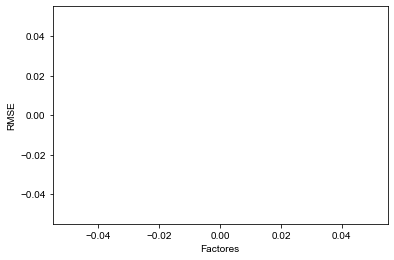

In [152]:
plt.xlabel('Factores')
plt.ylabel('RMSE')
sns.set()
sns.scatterplot(factores, rmse_test)

In [153]:
print('RMSE con 1 factor', rmse_test[0])

RMSE con 1 factor nan


Como conclusión, una vez estudiado el estado del arte, pude realizar el EDA correspondiente, relicé las preguntas que me parecían interesantes, apliqué indice similaridad coseno para la matriz, de manera que pude predecir, en base a procesamiento de lenguaje natural, similitudes entre los juegos, y definí una función que prediga en base al juego que seleccionaba el jugador, y sus gustos 5 juegos.
También pude generar una evaluación del puntaje asignado a cada juego en función de las horas jugadas por los distintos jugadores y un puntaje asignado por el mismo.

Para pensar, investigar y, opcionalmente, implementar
¿Cómo harías para ponerle un valor a la calificación?
¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
¿Hay algo que te gustaría investigar o probar?

## PARTE C - Próximos pasos

### Rehacer. Agregar preguntas extras a responder con el dataset, indicando que metodología seguiría para implementarlo.
## PARTE C - Resultados esperados

### Rehacer. Para el nuevo problema a resolver, indicar que se espera obtener como resultado una vez implementado.

En función a la devolución recibida, envío la resolución que a mi parecer resulta faltante.

Preguntas extras a responder con el Dataset:
Cuando se produce la mayoría de lanzamientos de videojuegos cada año en las plataformas.
Cuantos videojuegos se han publicados por año
Como fue el Crecimiento de lanzamiento de los mismos.  
Cuando se produce el mayor tiempo de juego de los usuarios.

Lo que se busca responder es cual es el momento ideal para lanzar un videojuego y cuando hacer las promociones de descuentos en función de los momentos que crece con mayor fuerza la cantidad de horas jugadas para maximizar los ingresos.



Realicemos un relevamiento de horas faltantes Las mismas representan el 0.37 del total de datos del dataframe, por lo tanto, con calcular el promedio de cada usuario sería una buen medida para imputarles a cada uno de ellos esas horas. Esto nos permitirá determinar las horas de todos los jugadores.

In [194]:
ordinalCategories = OrdinalEncoder(dtype=int).fit_transform(data_reviews[['username', 'product_id']])
X = np.c_[ordinalCategories, data_reviews.hours]
                                                            
data_imputed = IterativeImputer(random_state=42).fit_transform(X)

In [195]:
# Reemplazado valores imputados en la serie
data_reviews.hours = data_imputed[:,2]

#### Procesamiento de fecha de lanzamiento

En éste apartado, se transformarán algunas fechas del dataset de videojuegos al formato correcto, la columna release_date además de contener fechas de tipo datetime y valores faltantes, tiene valores categóricos del cual es posible convertirlos a datetime gracias a que algunos de ellos siguen el mismo patrón o comportamiento. 
Para el dataset de utilidades, no será necesario éste tipo de tratamiento.

In [158]:
data_games.release_date.value_counts()

2017-10-31    47
2017-12-01    44
2017-09-01    42
2017-09-15    40
2017-12-15    40
              ..
2005-05-01     1
2008-03-19     1
2008-08-31     1
2011-01-28     1
1996-06-17     1
Name: release_date, Length: 3136, dtype: int64

La siguiente función servirá para obtener aquellos valores que no corresponden a fechas válidas para poder examinar los valores categóricos:

In [159]:
def isDateValid(x): 
    try:
        return datetime.datetime.strptime(x, '%Y-%m-%d')        
    except:
        return False

In [160]:
invalid_date_games = data_games.query('release_date.notna()', engine='python')
invalid_date_games = pd.DataFrame([i for i in invalid_date_games.itertuples() 
                                   if not isDateValid(i.release_date)])
invalid_date_games.release_date

0                Feb 2011
1                Jul 2010
2                Jun 2009
3                Jan 2010
4                Jun 2009
              ...        
231                  Soon
232                Soon..
233          January 2018
234    Please wait warmly
235               H2 2018
Name: release_date, Length: 236, dtype: object

De las categorías mostradas, las que tienen el nombre del mes (completo o abreviado) y año es posible convertirlas. El nombre de la temporada y el año presentan el mismo caso. **Ejemplos: Nov 2020, November 2020, Winter 2020, Summer 2020...**

* Para empezar, la función a continuación retorna el número del mes basado en el nombre, gracias a una de las librerías incluidas en Python.

In [161]:
def get_month(month):
    if len(month) > 3:
        return strptime(month, '%B').tm_mon
    else:
        return strptime(month, '%b').tm_mon

In [162]:
print('Noviembre:', get_month('Nov'))
print('Noviembre:', get_month('November'))
print('Abril:', get_month('Apr'))
print('Abril:', get_month('April'))

Noviembre: 11
Noviembre: 11
Abril: 4
Abril: 4


* Ésta función obtiene una fecha como variable categórica y la transforma a datetime, si no corresponde al patron detectado la convierte a valor faltante. El resto de fechas no están definidas por un comportamiento, por lo tanto no es posible transformarlas una por una, y son mas de 100 categorías.

In [163]:
def get_date(date_sring):
    try:
        #Las temporadas se definirarán según el país, en éste caso es Estados Unidos. 
        #El diccionario contiene el nombre de la temporada y el mes en que inicia:
        SEASONS = {'Winter': 12, 'Summer': 7, 'Fall': 10, 'Spring': 4}
        sep = date_sring.split()
        # Primero verifica si es una temporada
        if sep[0] in SEASONS.keys():
            return datetime.datetime(year=int(sep[1]), month=SEASONS.get(sep[0]), day=1).date()

        # Sino, utiliza la función anterior para obtener el número del mes a partir del nombre.
        return datetime.datetime(year=int(sep[1]), month=get_month(sep[0]), day=1).date()
    except:
        # Retorna valor faltante si no se cumplen los dos casos, no es posible hacer más magia!!
        return np.nan

In [164]:
print('Noviembre', get_date('Nov 2020'))
print('Noviembre', get_date('November 2020'))
print('Verano', get_date('Summer 2020'))
print('Winter', get_date('Winter 2020'))

Noviembre 2020-11-01
Noviembre 2020-11-01
Verano 2020-07-01
Winter 2020-12-01


* Transformando fechas categóricas:


In [165]:
invalid_date_games.release_date = invalid_date_games.release_date.apply(lambda x: f'{get_date(x)}')
invalid_date_games.release_date

0      2011-02-01
1      2010-07-01
2      2009-06-01
3      2010-01-01
4      2009-06-01
          ...    
231           nan
232           nan
233    2018-01-01
234           nan
235           nan
Name: release_date, Length: 236, dtype: object

* Aplicando cambios sobre el dataframe original

In [166]:
invalid_idx = invalid_date_games.Index.values
data_games.loc[invalid_idx,
               'release_date'] = invalid_date_games.release_date.values

* Verificando los cambios en los índices donde previamente existían éstas categorías:

In [167]:
data_games.loc[invalid_idx].head()

,genres,app_name,release_date,id,publisher,url,categories,category_price
520,[Racing],Test Drive Unlimited 2,2011-02-01,9930,Atari,http://store.steampowered.com/app/9930/Test_Dr...,"['action', 'adventure', 'arcade', 'atmospheric...",paid
17404,[Action],Aliens vs Predator™ Bughunt Map Pack,2010-07-01,10697,SEGA,http://store.steampowered.com/app/10697/Aliens...,"['action', 'coop', 'downloadable content', 'mu...",paid
17604,"[Sports, Action]",Smashball,2009-06-01,17730,Smashball Labs LLC,http://store.steampowered.com/app/17730/Smashb...,"['action', 'fps', 'free to play', 'mod', 'mods...",free
17467,"[Strategy, Simulation]",Grand Ages: Rome - Reign of Augustus,2010-01-01,23455,Kalypso Media Digital,http://store.steampowered.com/app/23455/Grand_...,"['city builder', 'historical', 'multiplayer', ...",paid
227,"[Adventure, Indie]",Blueberry Garden,2009-06-01,29160,Erik Svedäng,http://store.steampowered.com/app/29160/Bluebe...,"['adventure', 'indie', 'puzzle', 'short', 'sin...",paid


Se ha completado el procedimiento de transformación de fecha de lanzamiento, con ésto es posible realizar un análisis exploratorio que conlleve Series de tiempo.

In [168]:
data_games.isna().sum()

genres               0
app_name             1
release_date      1614
id                   0
publisher         2915
url                  0
categories           0
category_price       0
dtype: int64

In [174]:
data_games.dtypes

genres            object
app_name          object
release_date      object
id                 Int64
publisher         object
url               object
categories        object
category_price    object
dtype: object

In [175]:
data_games['release_date'] = pd.to_datetime(data_games['release_date'], errors ='coerce')

In [176]:
data_games.dtypes

genres                    object
app_name                  object
release_date      datetime64[ns]
id                         Int64
publisher                 object
url                       object
categories                object
category_price            object
dtype: object

In [177]:
# Creando nueva columna para nombre del mes
games = data_games.assign(
    month_name=data_games.release_date.dt.month_name(),
    year=data_games.release_date.dt.year
)

In [178]:
# Frecuencia de cada mes
games_month = games.month_name.value_counts()

# Pasando objeto value_counts a DataFrame
games_month = pd.DataFrame(
    {'month_name': games_month.index, 'amount': games_month.values})

# Creando el numero del mes
games_month['n_month'] = pd.to_datetime(
    games_month.month_name, format='%B', errors='coerce').dt.month

# Ordenando por numero de mes
games_month.sort_values(by='n_month', inplace=True)

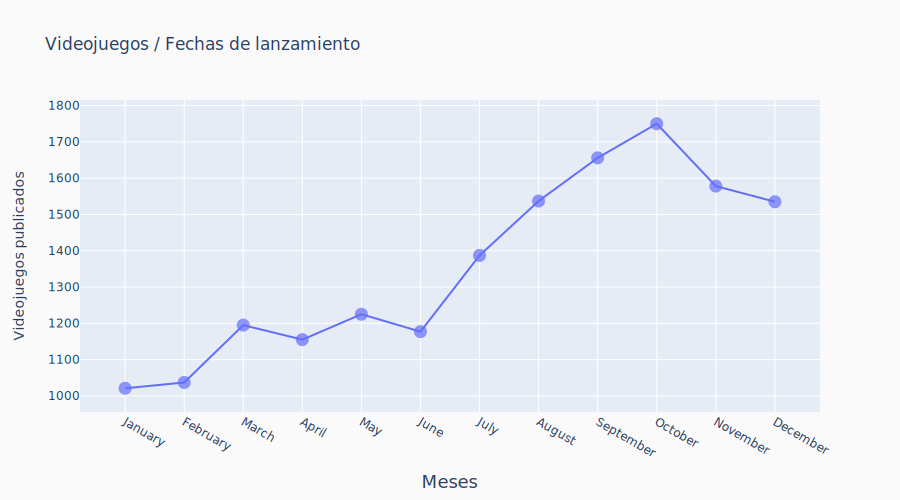

In [179]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=games_month.month_name,
    y=games_month.amount,
    marker={'size': 13, 'opacity': .7}
))
fig.update_layout( 
    paper_bgcolor='#FAFAFA',
    title='Videojuegos / Fechas de lanzamiento',
    autosize=False,
    height=500,
    width=900,
    hoverdistance=100,
    spikedistance=1000,
    xaxis=dict(
        title_text='Meses',
        titlefont=dict(size=18),
        showspikes=True,
        spikethickness=2,
        spikedash="dot",
        spikecolor="#999999",
        spikemode="across"),
    yaxis=dict(title_text="Videojuegos publicados")
)
#fig.show()
display(SVG(fig.to_image(format='svg')))

La mayoría de los videojuegos pueden estar siguiendo una estrategia de marketing lo cual explica que el número de publicaciones se acrecenta enormemente en los últimos meses del año.

### Videojuegos publicados por año

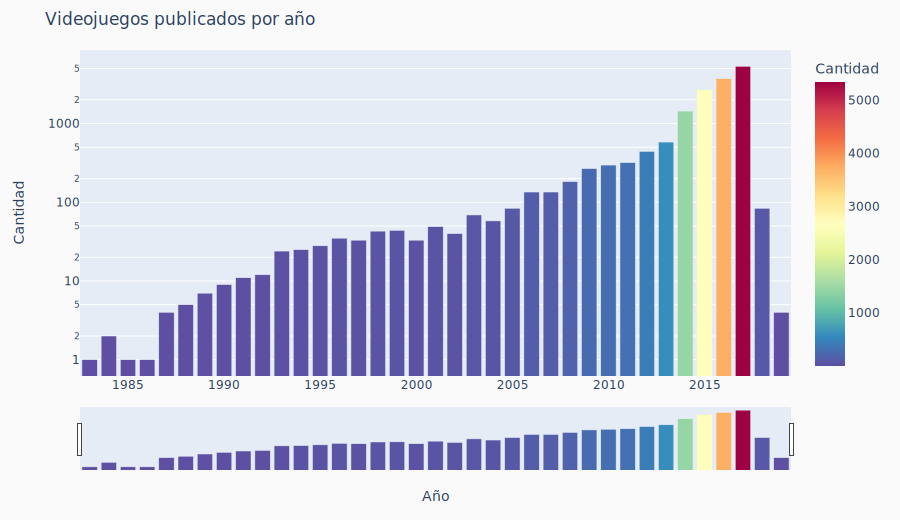

In [180]:
games_year = games.year.value_counts()
fig = px.bar(x=games_year.index, y=games_year.values, labels={
             'x': 'Año', 'y': 'Cantidad', 'color': 'Cantidad'},
             color=games_year.values,
             title='Videojuegos publicados por año',
             color_continuous_scale='spectral_r',
             width=900,
             height=520,
             log_y=True
             )

fig.update_layout(paper_bgcolor='#FAFAFA',
                  margin=dict(t=50, b=50)
                  )
fig.update_xaxes(rangeslider_visible=True)

#fig.show()
display(SVG(fig.to_image(format='svg')))

La cantidad de videojuegos en escala logarítmica. Se evidencia un aumento en la producción de videojuegos al pasar de los años, sin embargo, los datos muestran un descenso brutal en los últimos dos años. 

In [181]:
users_by_month = data_reviews.assign(month_name=data_reviews.date.dt.month_name())

users_by_month = users_by_month.month_name.value_counts()

users_by_month = pd.DataFrame(
    {'month_name': users_by_month.index, 'amount': users_by_month.values})

users_by_month['month_number'] = pd.to_datetime(users_by_month.month_name,
                                                format='%B', errors='coerce').dt.month

users_by_month.sort_values(by='month_number', inplace=True)
users_by_month

,month_name,amount,month_number
4,January,318981,1
8,February,245532,2
10,March,231286,3
11,April,215250,4
9,May,231412,5
2,June,360112,6
3,July,330274,7
5,August,269507,8
7,September,247771,9
6,October,267135,10


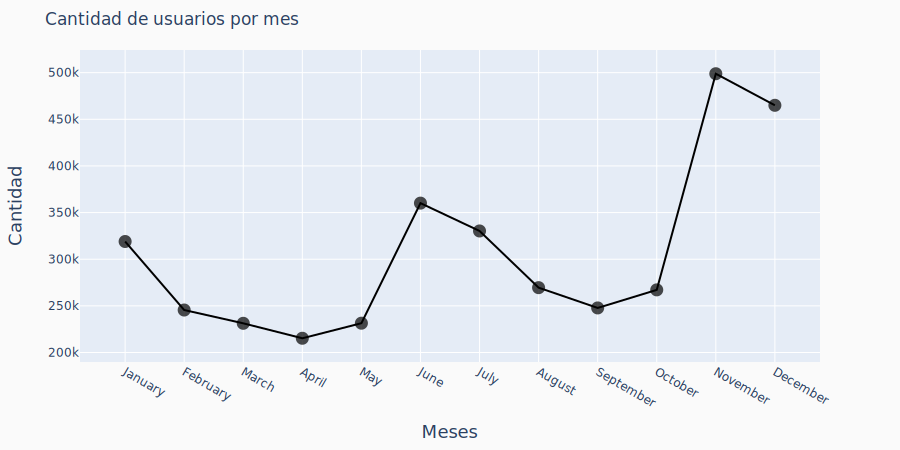

In [182]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=users_by_month.month_name,
    y=users_by_month.amount,
    line={'color': '#000000'},
    marker={'size': 13, 'opacity': .7},
))
fig.update_layout(
    paper_bgcolor='#FAFAFA',
    title='Cantidad de usuarios por mes',
    autosize=False,
    width=900,
    height=450,
    hoverdistance=100,
    spikedistance=1000,
    margin=dict(t=50),
    xaxis=dict(
        title_text='Meses',
        titlefont=dict(size=18),
        showspikes=True,
        spikethickness=3,
        spikedash="dot",
        spikecolor="red",
        spikemode="across"),
    yaxis=dict(title_text="Cantidad",  titlefont=dict(size=18))
)
#fig.show()
display(SVG(fig.to_image(format='svg')))

Vemos que se presentan 3 picos en la gráfica: A inicios, mitad y fin de año, lo cual puede estar relacionado a las temporadas de verano e invierno en Estados Unidos, en éstas épocas se concentran la mayoría de usuarios e invierten más horas de su tiempo libre en videojuegos de Steam.

Como conclusión y en función a las preguntas que nos realizamos oportunamente, nos parece importante las conclusiones que nos permite conocer este análisis de series de tiempo sobre los momentos que mayor horas de juego se dispone para jugar.

En este caso la estrategia de cada juego podría ser que se lance un par de meses antes del verano, para que con una buena estrategia publicitaria (a través de promociones, ej, juega gratis por un mes) se haaga conocido en la previa de los momentos donde mayor horas de juego le van a dedicar. 

Además también nos permitiría, por ejemplo otorgar promociones de descuentos para los meses donde no se juegan tantas horas, a fin también de incrementar las horas y lograr incrementar el nivel de interés en el juego.

Se Adjunta repositorio de github donde consta el archivo del Trabajo
https://github.com/sebabertaina/Datascientist-ds51-Trabajo-N-3